# TM10007 Assignment template

In [19]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/jveenland/tm10007_ml.git
!pip install -q --upgrade git+https://github.com/StijnHuitenga/TM10007_ML_Project.git

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done


## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [84]:
# Data loading functions. Uncomment the one you want to use
#from worcgist.load_data import load_data
from worclipo.load_data import load_data
# from worcliver.load_data import load_data
import pandas as pd
#from ecg.load_data import load_data
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import model_selection
from sklearn import metrics
from sklearn import feature_selection
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import svm
from sklearn.model_selection import train_test_split

data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

# feature space splitsen in labels en features
features = pd.DataFrame(data)
ground_truth = data['label']
features.pop('label')
ground_truth = ground_truth.map(lambda x: 1 if x == 'liposarcoma' else 0)

#features met alleen maar missing data verwijderen
zero_columns = [column for column in features.columns if (features[column] == 0).all()]
features = features.drop(columns=zero_columns)
print(f'The number of features (without missing data features): {len(features.columns)}')

#split data
X_train, X_test, y_train, y_test = train_test_split(features, ground_truth, test_size=0.2, random_state=42)
print(f"Aantal samples in training set: {len(X_train)}")
print(f"Aantal samples in test set: {len(X_test)}")

The number of samples: 115
The number of columns: 494
The number of features (without missing data features): 480
Aantal samples in training set: 92
Aantal samples in test set: 23


In [74]:
# num_cols = X_train.select_dtypes(include=['number']).columns  # Alleen numerieke kolommen
# num_features = len(num_cols)  # Aantal numerieke features
# print(num_features)
# # Instellingen voor het plotten van meerdere histogrammen
# plt.figure(figsize=(15, 12))
# for i, col in enumerate(num_cols[:494]):  # Eerst 20 kolommen om het overzichtelijk te houden
#     plt.subplot(50, 10, i + 1)  # 4 rijen, 5 kolommen per plotpagina
#     sns.histplot(data[col], bins=30, kde=True)
#     plt.title(col)
#     plt.xlabel("")
#     plt.ylabel("Frequentie")

# plt.tight_layout()
# plt.show()

In [78]:
from scipy.stats import shapiro
normal_count = 0
not_normal_count = 0
for col in X_train:
  stat, p = shapiro(X_train[col])
  if p > 0.05:
      normal_count += 1
  else:
      not_normal_count += 1
print(normal_count)
print(not_normal_count)
# dus we kiezen voor normalization want data is voor veel features niet normaal verdeeld

72
408


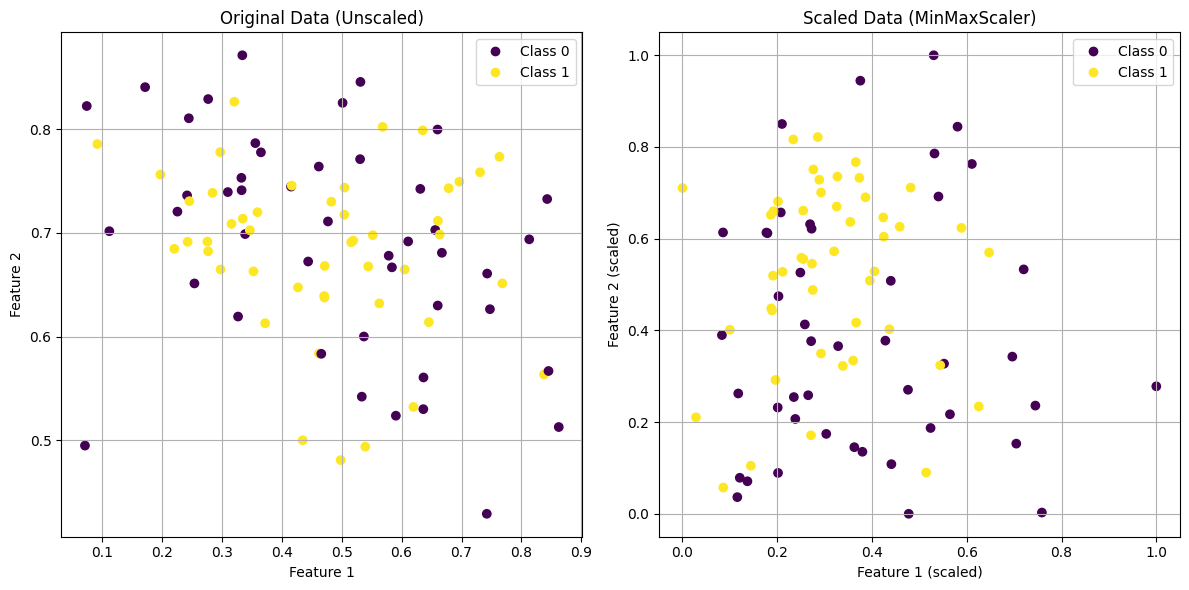

ValueError: when `importance_getter=='auto'`, the underlying estimator SVC should have `coef_` or `feature_importances_` attribute. Either pass a fitted estimator to feature selector or call fit before calling transform.

In [111]:
# scaling
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# #scaling plotten op de eerste twee features
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)  # Eerste subplot
scatter = plt.scatter(X_train.iloc[:, 0], X_train.iloc[:, 200], c=y_train, label='Original data') #let op, deze plot is anders doordat je een dataframe hebt
plt.title('Original Data (Unscaled)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(handles=scatter.legend_elements()[0], labels=['Class 0', 'Class 1'])
plt.grid(True)

plt.subplot(1, 2, 2)  # Tweede subplot
scatter = plt.scatter(X_train_scaled[:, 80], X_train_scaled[:, 1], c=y_train, label='Scaled data') #hier heb je te maken met numpy arrays
plt.title('Scaled Data (MinMaxScaler)')
plt.xlabel('Feature 1 (scaled)')
plt.ylabel('Feature 2 (scaled)')
plt.legend(handles=scatter.legend_elements()[0], labels=['Class 0', 'Class 1'])
plt.grid(True)
plt.tight_layout()
plt.show()

# feature selectie
svc = svm.SVC(kernel="poly")
rfecv = feature_selection.RFECV(
    estimator=svc, step=1,
    cv=model_selection.StratifiedKFold(8),
    scoring='accuracy')
rfecv.fit(X_train_scaled, y_train)
print("Optimal number of features : %d" % rfecv.n_features_)
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.cv_results_["mean_test_score"]) + 1), rfecv.cv_results_["mean_test_score"])
plt.show()


In [109]:
## Finding ID's with missing feature values
zero_value_feature = {}
for id in features.index:
    if (features.loc[id] == 0).any():
        zero_columns = features.columns[features.loc[id] == 0].tolist()  # Find columns where value is 0
        zero_value_feature[id] = zero_columns
    else:
        continue